In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from superres import superres_metrics, ssim, psnr
from superres import RRDB_Net, MultiImageToMultiChannel, TwoXModel, TwoYLoss, MultiToMultiImageList, TransformableLists
import czifile
from superres.helpers import get_czi_shape_info, build_index
import imageio
import adabound

datasetname = 'multiframe_002'
data_path = Path('/scratch/bpho')
datasets = data_path/'datasets'
datasources = data_path/'datasources'
dataset = datasets/datasetname

hr_path = dataset/'hr'
lr_path = dataset/'lr'
lr_up_path = dataset/'lr_up'

In [2]:
from numbers import Integral

class MultiImage(ItemBase):
    def __init__(self, img_list):
        self.img_list = img_list

    def __repr__(self):
        return f'MultiImage: {[str(img) for img in self.img_list]}'

    @property
    def size(self):
        return [img.size for img in self.img_list]
    
    @property
    def data(self):
        img_data = torch.stack([img.data for img in self.img_list])
        num_img, c, h, w = img_data.shape
        data = tensor(img_data.view(num_img*c, h, w))
        return data

    def apply_tfms(self, tfms, **kwargs):
        first_time = True

        save_img_list = []
        for img in self.img_list:
            new_img = img.apply_tfms(tfms, do_resolve=first_time, **kwargs)
            first_time = False
            save_img_list.append(new_img)
        self.img_list = save_img_list
        return self
    
    def _repr_png_(self): return self._repr_image_format('png')
    def _repr_jpeg_(self): return self._repr_image_format('jpeg')

    def _repr_image_format(self, format_str):
        #return self.img_lists[0]._repr_image_format(format_str)
        with BytesIO() as str_buffer:
            img_data = np.concatenate([image2np(img.px) for img in self.img_list], axis=1)
            plt.imsave(str_buffer, img_data, format=format_str)
            return str_buffer.getvalue()

    def show(self, **kwargs):
        self.img_list[0].show(**kwargs)

        
class MultiImageList(ImageList):
    "`ItemList` suitable for computer vision."
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.channels = 1
        
    def open(self, fn):
        img_data = np.load(fn)
        img_list = []
        #for i in range(img_data.shape[0]):
        for i in range(1,4):
            img_list.append(Image(tensor(img_data[i][None])))
        
        self.channels = img_list[0].data.shape[0]
        return MultiImage(img_list)
        
    def reconstruct(self, t:Tensor):
        #set_trace()
        n, h, w = t.shape
        n //= self.channels
        one_img = t.view(self.channels,n*h,w)
        return Image(one_img.float().clamp(min=0,max=1))

class NpyRawImageList(ImageList):
    def open(self, fn):
        img_data = np.load(fn)
        return Image(tensor(img_data[None]))

    def analyze_pred(self, pred):
        return pred[0:1]

    def reconstruct(self, t):
        return Image(t.float().clamp(min=0,max=1))                

class MultiImageImageList(MultiImageList):
    _label_cls,_square_show,_square_show_res = NpyRawImageList,False,False

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys`(targets)  on a figure of `figsize`."
        axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize)
        for i, (x,y) in enumerate(zip(xs,ys)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,1], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Input / Prediction / Target'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,2], **kwargs)
            z.show(ax=axs[i,1], **kwargs)

In [3]:
def map_to_hr(x):
    hr_name = x.relative_to(lr_path)
    return hr_path/hr_name

def get_src(size=128, scale=1):
    if scale != 1: use_lr_path = lr_path
    else: use_lr_path = lr_path
        
    def map_to_hr(x):
        hr_name = x.relative_to(use_lr_path)
        return hr_path/hr_name
    
    src = (MultiImageImageList
            .from_folder(lr_path, extensions=['.npy'])
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def get_data(bs, size, scale=1, max_zoom=1.):
    src = get_src(size, scale=scale)    
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    #tfms = [[],[]]
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size*scale)
            .databunch(bs=bs).normalize(do_y=False))
    return data

In [4]:
torch.cuda.device_count()

2

In [5]:
bs = 16
size = 128
data = get_data(bs, size, scale=4, max_zoom=1.2)

in_c = 3
out_c = 1
nf = 64
gcval = 32 # 32
nb = 8 # 23

loss = F.mse_loss
model = RRDB_Net(3, 1, nf, nb, gc=gcval )
model = nn.DataParallel(model)
#opt_func = partial(adabound.AdaBound,  lr=1e-6)

In [6]:
learn = Learner(data, model, loss_func=loss) # callback_fns=LossMetrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.to_fp16()
gc.collect()

27

In [7]:
x,y = learn.data.one_batch()
x.shape, y.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 512, 512]))

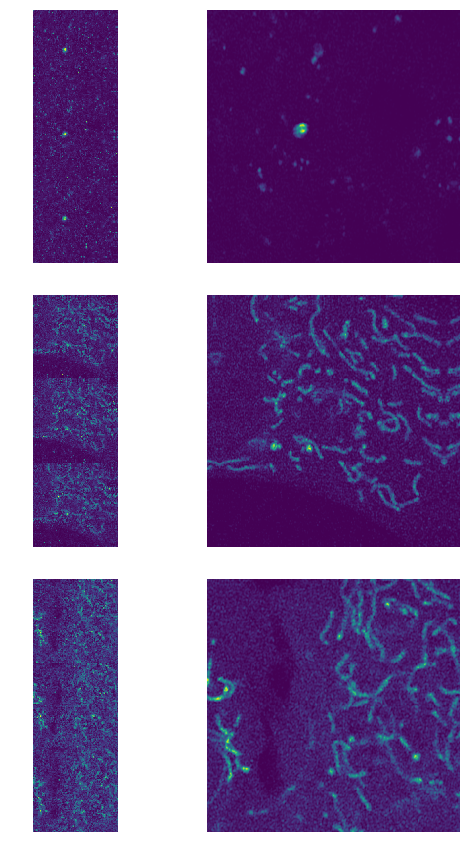

In [8]:
learn.data.show_batch(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


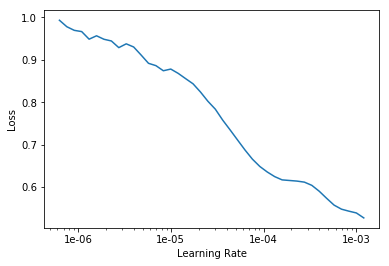

In [9]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-4)
#learn.fit(4, m)

In [ ]:
learn.show_results(rows=3, imgsize=5)

In [ ]:
learn.save('rrdb_5.3')


In [ ]:
movie_files = []
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))
#movie_files += list(Path('/scratch/bpho/datasources/low_res_test/').glob('low res confocal*.czi'))

#movie_files += list(Path('/scratch/bpho/datasources/neuron_movies2/').glob('low*.*'))

In [ ]:
movie_files = movie_files[0:2]

In [ ]:
def image_from_tiles(learn, in_img, tile_sz=128, scale=4, wsize=3):
    cur_size = in_img.shape[1:3]
    c = in_img.shape[0]
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    w, h = cur_size
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((1,w*scale,h*scale))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = tensor(in_img[:,x_start:x_end, y_start:y_end])
            
            img_list = [Image(in_tile[i][None]) for i in range(wsize)]
            tlist = MultiImage(img_list)
            
            out_tile,_,_ = learn.predict(tlist)
            
            out_x_start = x_start * scale
            out_x_end = x_end * scale
            out_y_start = y_start * scale
            out_y_end = y_end * scale

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = (x_end-x_start) * scale
            in_y_end = (y_end-y_start) * scale
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img

In [ ]:
def tif_predict_movie(learn, tif_in, orig_out='orig.tif', pred_out='pred.tif', size=128, wsize=3):
    im = PIL.Image.open(tif_in)
    im.load()
    times = im.n_frames
    #times = min(times,100)
    imgs = []
    for i in range(times):
        im.seek(i)
        imgs.append(np.array(im).astype(np.float32)/255.)
    img_data = np.stack(imgs)
    
    def pull_frame(i):
        im.seek(i)
        im.load()
        return np.array(im)
    
    preds = []
    origs = []
    img_max = img_data.max()
    print(img_max)
    print('max: ', img_max)
    for t in progress_bar(list(range(0,times-wsize+1))):
        img = img_data[t:(t+wsize)].copy()
        img /= img_max
        
        out_img = image_from_tiles(learn, img, tile_sz=size, wsize=wsize)
        pred = (out_img*255).cpu().numpy().astype(np.uint8)
        preds.append(pred)
        orig = (img[1][None]*255).astype(np.uint8)
        origs.append(orig)

    all_y = np.concatenate(preds)
    #print(all_y.shape)
    imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
    all_y = np.concatenate(origs)
    #print(all_y.shape)
    imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128, wsize=3):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        #times = min(times, 100)
        x,y = proc_shape['X'], proc_shape['Y']
        print(f'czi: x:{x} y:{y} t:{times} z:{depths}')
        
        
        data = czi_f.asarray().astype(np.float32)/255.
        preds = []
        origs = []
        
        img_max = data.max()
        print(img_max)
        for t in progress_bar(list(range(0,times-wsize+1))):
            idx = build_index(proc_axes, {'T': slice(t,t+wsize), 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].copy()
            img /= img_max
            
            out_img = image_from_tiles(learn, img, tile_sz=size, wsize=wsize)
            pred = (out_img*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[1][None]*255).astype(np.uint8)
            origs.append(orig)
            
        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)
        

In [ ]:
bs = 4
size = 230
data = get_data(bs, size, scale=4)

loss = F.mse_loss
model = RRDB_Net(3, 1, nf, nb, gc=gcval )
#model = nn.DataParallel(model) 

learn = Learner(data, model, loss_func=loss)
learn = learn.load('rrdb_5.3').to_fp16()
gc.collect()

In [ ]:
x,y = data.one_batch()
print(x.shape, y.shape)

In [ ]:
for fn in progress_bar(movie_files):
    #try:
        pred_name = f'{fn.stem}_pred.tif'
        orig_name = f'{fn.stem}_orig.tif'
        if not Path(pred_name).exists():
            if fn.suffix == '.czi':
                print(f'czi {fn.stem}')
                czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name, wsize=5)
            elif fn.suffix == '.tif':
                tif_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name, wsize=5)
                tif_fn = fn
                print(f'tif {fn.stem}')
        else:
            print(f'skip: {fn.stem}')
    #except:
    #    print(f'err: {fn.stem}')

In [ ]:
%debug

In [ ]:
im = PIL.Image.open(tif_fn)
im.load()
im.n_frames

In [ ]:
im.seek(3)
np.array(im).shape

In [ ]:
images = list(PIL.ImageSequence.Iterator(im))

In [ ]:
w_imgs = images[0:3]

In [ ]:
img = np.stack([np.array(img) for img in w_imgs]).shape

In [ ]:
w_imgs[2]

In [ ]:
fn

In [ ]:
!ls -hatlr *.tif

In [ ]:
%debug

In [ ]:
x.shape

In [ ]:
doc(conv_layer)

In [ ]:
%debug